# Make Water Vapor Profile

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import climlab
import xarray as xr
import scipy.integrate as sp 
import matplotlib.offsetbox as offsetbox
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings
from climlab_rrtmg import rrtmg_lw, rrtmg_sw
from __future__ import division, print_function, absolute_import
import numpy as np
import warnings
from climlab import constants as const
from climlab.radiation.radiation import _Radiation_SW
from climlab.radiation.rrtm.utils import _prepare_general_arguments
from climlab.radiation.rrtm.utils import _climlab_to_rrtm, _climlab_to_rrtm_sfc, _rrtm_to_climlab


warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

#### All additionally defined stuff is below
Great if we can import all these

In [307]:
# model parameters
nbndsw = int(rrtmg_sw.parrrsw.nbndsw)
naerec = int(rrtmg_sw.parrrsw.naerec)
ngptsw = int(rrtmg_sw.parrrsw.ngptsw)
nbndlw = int(rrtmg_lw.parrrtm.nbndlw)
ngptlw = int(rrtmg_lw.parrrtm.ngptlw)

last_cldfmcl = [[],[],[],[],[]]

# arrays to map band varying values to g-point varying values.
g2band_sw = np.array([ 0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,
        8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10,
       10, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13])
g2band_lw = np.array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10,
       10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 13, 13,
       14, 14, 15, 15])

# function to compute layer thickness from pressure levels, needed for calculation alpha
def dz_from_p(p_lev,ptoa=1e-5): # using _bounding_ pressure (mb) to approximate layer thickness in meters
    # assume a non-zero top of atmosphere pressure
    # source of fit: ERA5 2022 annual zonal mean geopotential height on pressure level over 0 degree latitude
    fit = np.array([-7193.75219011, 50217.56455353])
    p_lev[p_lev==0] += ptoa
    z_lev = fit[0]*np.log(p_lev)+fit[1]
    dz = z_lev[:-1]-z_lev[1:]
    return dz

# Constants for latitude and day-of-year dependent decorrelation length (Oreopolous et al., 2012)
am1 = 1.4315
am2 = 2.1219
am4 = -25.584
amr = 7.0

def get_alpha(iplon, nlayers, idcor, decorr_con, dz, lat, juldat, cldfrac):
    # we only do icld = 4!!
    # Calculate decorrelation length
    if idcor == 1:
        # Calculate day-of-year dependent component
        if juldat > 181:
            am3 = -4 * amr / 365 * (juldat - 272)
        else:
            am3 = 4 * amr / 365 * (juldat - 91)
        # Calculate latitude dependent decorrelation length in meters
        decorr_lat = am1 + am2 * np.exp(-((lat - am3) ** 2) / (am4 ** 2))
        decorr_len = decorr_lat * 1e3
    else:
        decorr_len = decorr_con
    
    decorr_inv = 1 / decorr_len if decorr_len >= 0 else 1.0

    alpha = np.zeros(nlayers)
    # Calculate alpha for each layer Exponential cloud overlap
    alpha[0] = 0.0
    for k in range(1, nlayers):
        alpha[k] = np.exp(-0.5 * (dz[k] + dz[k-1]) * decorr_inv)
    
    return alpha
    
def sample_exp_overlap(nsubcol,nlayers,cldf,alpha,seed=0):
    np.random.seed(seed)
    CDF = np.zeros((nsubcol, nlayers))
    CDF2 = np.zeros((nsubcol, nlayers))

    for isubcol in range(nsubcol):
        for ilev in range(nlayers):
            rand_num =  np.random.rand()
            CDF[isubcol, ilev] = rand_num
            rand_num =  np.random.rand()
            CDF2[isubcol, ilev] = rand_num
    # Generate vertical correlations in random number arrays: bottom to top
    for ilev in range(1, nlayers):
        # Assuming spread function is defined to work similarly to Fortran spread
        # Assuming alpha is an array of values for each layer
        condition = CDF2[:, ilev] < alpha[ilev]
        CDF[:, ilev][condition] = CDF[:, ilev - 1][condition]
        
    # Initialize the 'iscloudy' array with the same shape as 'CDF'
    iscloudy = np.zeros(CDF.shape, dtype=bool)
    for ilev in range(nlayers):  # Python is 0-indexed
        # The 'np.newaxis' is used to broadcast 'cldf' across the 'nsubcol' dimension
        threshold = 1.0 - cldf[ilev]
        iscloudy[:, ilev] = (CDF[:, ilev] >= threshold)
    iscloudy = np.float_(iscloudy)
    return CDF,iscloudy

def exponential_sw(ncol, nlay, dz, permuteseed, play,
                        cldfrac, ciwp, clwp, reic, relq, tauc, ssac, asmc, fsfc):
                        # latter four has shape band, 1, nlay
    alpha = get_alpha(None, nlay, 1, None, dz, 0, 180, cldfrac.flatten())
    tauc_g,ssac_g,asmc_g,fsfc_g = np.zeros((ngptsw,1,nlay)),np.zeros((ngptsw,1,nlay)),np.zeros((ngptsw,1,nlay)),np.zeros((ngptsw,1,nlay))
    for i in range(ngptsw):
        tauc_g[i] = tauc[g2band_sw[i]]
        ssac_g[i] = ssac[g2band_sw[i]]
        asmc_g[i] = asmc[g2band_sw[i]]
        fsfc_g[i] = fsfc[g2band_sw[i]]
    CDF,iscloudy = sample_exp_overlap(ngptsw,nlay,cldfrac.flatten(),alpha,permuteseed)
    iscloudy = iscloudy[:,None,:]
    #print(cldfrac.shape,iscloudy.shape,tauc.shape,ciwp.shape,reic.shape, ssac.shape, asmc.shape, fsfc.shape)
    zeroarr = np.zeros((ngptsw,1,nlay))
    cldfmcl, ciwpmcl, clwpmcl, reicmcl, relqmcl, taucmcl, ssacmcl, asmcmcl, fsfcmcl = \
        zeroarr.copy(),zeroarr.copy(),zeroarr.copy(),zeroarr.copy(),zeroarr.copy(),zeroarr.copy(),zeroarr.copy(),zeroarr.copy(),zeroarr.copy()
    cldfmcl[np.where(iscloudy==1)] = 1
    taucmcl[np.where(iscloudy==1)] = tauc_g[np.where(iscloudy==1)]
    ssacmcl[np.where(iscloudy==1)] = ssac_g[np.where(iscloudy==1)]
    asmcmcl[np.where(iscloudy==1)] = asmc_g[np.where(iscloudy==1)]
    fsfcmcl[np.where(iscloudy==1)] = fsfc_g[np.where(iscloudy==1)]
    ciwpmcl[np.where(iscloudy==1)] += ((ciwpmcl*0+1)*ciwp[None,:])[np.where(iscloudy==1)]
    clwpmcl[np.where(iscloudy==1)] += ((clwpmcl*0+1)*clwp[None,:])[np.where(iscloudy==1)]

    return (cldfmcl, ciwpmcl, clwpmcl, reic.copy(), relq.copy(), taucmcl, ssacmcl, asmcmcl, fsfcmcl)

def exponential_lw(ncol, nlay, dz, permuteseed, play,
                        cldfrac, ciwp, clwp, reic, relq, tauc):
                        # latter four has shape band, 1, nlay
    alpha = get_alpha(None, nlay, 1, None, dz, 0, 180, cldfrac.flatten())
    tauc_g = np.zeros((ngptlw,1,nlay))
    for i in range(ngptlw):
        tauc_g[i] = tauc[g2band_lw[i]]
    CDF,iscloudy = sample_exp_overlap(ngptlw,nlay,cldfrac.flatten(),alpha,permuteseed)
    iscloudy = iscloudy[:,None,:]
    #print(cldfrac.shape,iscloudy.shape,tauc.shape,ciwp.shape,reic.shape, ssac.shape, asmc.shape, fsfc.shape)
    zeroarr = np.zeros((ngptlw,1,nlay))
    cldfmcl, ciwpmcl, clwpmcl, reicmcl, relqmcl, taucmcl = \
        zeroarr.copy(),zeroarr.copy(),zeroarr.copy(),zeroarr.copy(),zeroarr.copy(),zeroarr.copy()
    cldfmcl[np.where(iscloudy==1)] = 1
    taucmcl[np.where(iscloudy==1)] = tauc_g[np.where(iscloudy==1)]
    ciwpmcl[np.where(iscloudy==1)] += ((ciwpmcl*0+1)*ciwp[None,:])[np.where(iscloudy==1)]
    clwpmcl[np.where(iscloudy==1)] += ((clwpmcl*0+1)*clwp[None,:])[np.where(iscloudy==1)]

    return (cldfmcl, ciwpmcl, clwpmcl, reic.copy(), relq.copy(), taucmcl)

# modified compute code that include mcica.
## put into another script?

# short wave part
def compute_sw(radmodel,nmcica=100):
    # get input to rrtmg sw
    (ncol, nlay, icld, iaer, permuteseed, irng,
            play, plev, tlay, tlev, tsfc,
            h2ovmr, o3vmr, co2vmr, ch4vmr, n2ovmr, o2vmr,
            aldif, aldir, asdif, asdir, coszen, adjes, dyofyr, scon, isolvar,
            indsolvar, bndsolvar, solcycfrac,
            inflgsw, iceflgsw, liqflgsw,
            cldfrac, ciwp, clwp, reic, relq, tauc, ssac, asmc, fsfc,
            tauaer, ssaaer, asmaer, ecaer,) = radmodel._prepare_sw_arguments()

    _swuflx, _swdflx, _swhr, _swuflxc, _swdflxc, _swhrc = [],[],[],[],[],[]
    for i in range(nmcica):
            if icld == 4:
                (cldfmcl, ciwpmcl, clwpmcl, reicmcl, relqmcl, taucmcl, ssacmcl, asmcmcl, fsfcmcl) = exponential_sw(ncol, nlay, dz, permuteseed+1000*i, play, cldfrac, ciwp, clwp, reic, relq, tauc, ssac, asmc, fsfc)
            else: 
                (cldfmcl, ciwpmcl, clwpmcl, reicmcl, relqmcl, taucmcl,
                ssacmcl, asmcmcl, fsfcmcl) = rrtmg_sw.climlab_mcica_subcol_sw(
                                ncol, nlay, icld, permuteseed+1000*i, irng, play, # permuteseed should have large spacing
                                cldfrac, ciwp, clwp, reic, relq, tauc, ssac, asmc, fsfc)

            (swuflx, swdflx, swhr, swuflxc, swdflxc, swhrc) = \
                    rrtmg_sw.climlab_rrtmg_sw(ncol, nlay, icld, iaer,
                        play, plev, tlay, tlev, tsfc,
                        h2ovmr, o3vmr, co2vmr, ch4vmr, n2ovmr, o2vmr,
                        asdir, asdif, aldir, aldif,
                        coszen, adjes, dyofyr, scon, isolvar,
                        inflgsw, iceflgsw, liqflgsw, cldfmcl,
                        taucmcl, ssacmcl, asmcmcl, fsfcmcl,
                        ciwpmcl, clwpmcl, reicmcl, relqmcl,
                        tauaer, ssaaer, asmaer, ecaer,
                        bndsolvar, indsolvar, solcycfrac)
            _swuflx.append(swuflx) 
            _swdflx.append(swdflx)
            _swhr.append(swhr)
            _swuflxc.append(swuflxc)
            _swdflxc.append(swdflxc)
            _swhrc.append(swhrc)
    swuflx = np.mean(np.array(_swuflx),axis=0)
    swdflx = np.mean(np.array(_swdflx),axis=0)
    swhr = np.mean(np.array(_swhr),axis=0)
    swuflxc = np.mean(np.array(_swuflxc),axis=0)
    swdflxc = np.mean(np.array(_swdflxc),axis=0)
    swhrc = np.mean(np.array(_swhrc),axis=0)
    
    #  Output is all (ncol,nlay+1) or (ncol,nlay)
    radmodel.SW_flux_up = _rrtm_to_climlab(swuflx) + 0.*radmodel.SW_flux_up
    radmodel.SW_flux_down = _rrtm_to_climlab(swdflx) + 0.*radmodel.SW_flux_down
    radmodel.SW_flux_up_clr = _rrtm_to_climlab(swuflxc) + 0.*radmodel.SW_flux_up_clr
    radmodel.SW_flux_down_clr = _rrtm_to_climlab(swdflxc) + 0.*radmodel.SW_flux_down_clr
    #  Compute quantities derived from fluxes, including ASR
    radmodel._compute_SW_flux_diagnostics()
    #  calculate heating rates from flux divergence
    SWheating_Wm2 = np.array(-np.diff(radmodel.SW_flux_net, axis=-1)) + 0.*radmodel.Tatm
    SWheating_clr_Wm2 = np.array(-np.diff(radmodel.SW_flux_net_clr, axis=-1)) + 0.*radmodel.Tatm
    radmodel.heating_rate['Ts'] = np.array(radmodel.SW_flux_net[..., -1, np.newaxis]) + 0.*radmodel.Ts
    radmodel.heating_rate['Tatm'] = SWheating_Wm2
    #  Convert to K / day
    Catm = radmodel.Tatm.domain.heat_capacity
    radmodel.TdotSW = SWheating_Wm2 / Catm * const.seconds_per_day
    radmodel.TdotSW_clr = SWheating_clr_Wm2 / Catm * const.seconds_per_day

    # save a sample cloud fraction profile
    last_cldfmcl[icld] = cldfmcl[:,0,::-1]

# longwave part
def compute_lw(radmodel,nmcica=100):
    (ncol, nlay, icld, ispec, permuteseed, irng, idrv, cp,
                play, plev, tlay, tlev, tsfc,
                h2ovmr, o3vmr, co2vmr, ch4vmr, n2ovmr, o2vmr,
                cfc11vmr, cfc12vmr, cfc22vmr, ccl4vmr, emis,
                inflglw, iceflglw, liqflglw,
                cldfrac, ciwp, clwp, reic, relq, tauc, tauaer,) = radmodel._prepare_lw_arguments()

    _uflx, _dflx, _uflxc, _dflxc = [],[],[],[]
    _olr_sr,_hr,_hrc,_duflx_dt,_duflxc_dt = [],[],[],[],[]
    for i in range(nmcica):
        #  Call the Monte Carlo Independent Column Approximation (McICA, Pincus et al., JC, 2003)
        if icld == 4:
                (cldfmcl, ciwpmcl, clwpmcl, reicmcl, relqmcl, taucmcl) = exponential_lw(ncol, nlay, dz, permuteseed+1000*i, play, cldfrac, ciwp, clwp, reic, relq, tauc)
        else: (cldfmcl, ciwpmcl, clwpmcl, reicmcl, relqmcl, taucmcl) = \
            rrtmg_lw.climlab_mcica_subcol_lw(
                        ncol, nlay, icld,
                        permuteseed+1000*i, irng, play, # permuteseed should have large spacing
                        cldfrac, ciwp, clwp, reic, relq, tauc)
            #  Call the RRTMG_LW driver to compute radiative fluxes
        (olr_sr, uflx, dflx, hr, uflxc, dflxc, hrc, duflx_dt, duflxc_dt) = \
            rrtmg_lw.climlab_rrtmg_lw(ncol, nlay, icld, ispec, idrv,
                    play, plev, tlay, tlev, tsfc,
                    h2ovmr, o3vmr, co2vmr, ch4vmr, n2ovmr, o2vmr,
                    cfc11vmr, cfc12vmr, cfc22vmr, ccl4vmr, emis,
                    inflglw, iceflglw, liqflglw, cldfmcl,
                    taucmcl, ciwpmcl, clwpmcl, reicmcl, relqmcl,
                    tauaer)
        _uflx.append(uflx) 
        _dflx.append(dflx)
        _uflxc.append(uflxc)
        _dflxc.append(dflxc)
        _olr_sr.append(olr_sr)
        _hr.append(hr)
        _hrc.append(hrc)
        _duflx_dt.append(duflx_dt)
        _duflxc_dt.append(duflxc_dt)
    uflx = np.mean(np.array(_uflx),axis=0)
    dflx = np.mean(np.array(_dflx),axis=0)
    uflxc = np.mean(np.array(_uflxc),axis=0)
    dflxc = np.mean(np.array(_dflxc),axis=0)
    olr_sr = np.mean(np.array(_olr_sr),axis=0)
    hr = np.mean(np.array(_hr),axis=0)
    hrc = np.mean(np.array(_hrc),axis=0)
    duflx_dt = np.mean(np.array(_duflx_dt),axis=0)
    duflxc_dt = np.mean(np.array(_duflxc_dt),axis=0)
    
    #  Output is all (ncol,nlay+1) or (ncol,nlay)
    radmodel.LW_flux_up = _rrtm_to_climlab(uflx) + 0.*radmodel.LW_flux_up
    radmodel.LW_flux_down = _rrtm_to_climlab(dflx) + 0.*radmodel.LW_flux_down
    radmodel.LW_flux_up_clr = _rrtm_to_climlab(uflxc) + 0.*radmodel.LW_flux_up_clr
    radmodel.LW_flux_down_clr = _rrtm_to_climlab(dflxc) + 0.*radmodel.LW_flux_down_clr
    #  Compute quantities derived from fluxes, including OLR
    radmodel._compute_LW_flux_diagnostics()
    # Except for spectrally-decomposed TOA flux, olr_sr (ncol, nbndlw)
    if radmodel.return_spectral_olr:
        #  Need to deal with broadcasting for two different cases: single column and latitude axis
        # case single column: self.OLR is (1,),  self.OLR_spectral is (1, nbndlw),  olr_sr is (1,nbndlw)
        #  squeeze olr_sr down to (nbndlw,)
        # then use np.squeeze(olr_sr)[..., np.newaxis, :] to get back to (1, nbndlw)
        # case latitude axis: self.OLR is (num_lat,1), self.OLR_spectral is (num_lat, 1, nbndlw), olr_sr is (num_lat, nbndlw)
        #  np.squeeze(olr_sr) has no effect in this case
        # add the newaxis because the domain has a size-1 depth axis ---> (num_lat, 1, nbndlw)
        radmodel.OLR_spectral = np.squeeze(olr_sr)[...,np.newaxis,:] + 0.*radmodel.OLR_spectral
    #  calculate heating rates from flux divergence
    LWheating_Wm2 = np.array(np.diff(radmodel.LW_flux_net, axis=-1)) + 0.*radmodel.Tatm
    LWheating_clr_Wm2 = np.array(np.diff(radmodel.LW_flux_net_clr, axis=-1)) + 0.*radmodel.Tatm
    radmodel.heating_rate['Ts'] = np.array(-radmodel.LW_flux_net[..., -1, np.newaxis]) + 0.*radmodel.Ts
    radmodel.heating_rate['Tatm'] = LWheating_Wm2
    #  Convert to K / day
    Catm = radmodel.Tatm.domain.heat_capacity
    radmodel.TdotLW = LWheating_Wm2 / Catm * const.seconds_per_day
    radmodel.TdotLW_clr = LWheating_clr_Wm2 / Catm * const.seconds_per_day

def step_model(radmodel_sw,radmodel_lw,nmcica=1):
    # iterate model, get heating rate
    compute_sw(radmodel_sw,nmcica)
    dTs_sw = radmodel_sw.heating_rate['Ts']/radmodel_sw.Ts.domain.heat_capacity*radmodel_sw.timestep
    dTa_sw = radmodel_sw.heating_rate['Tatm']/radmodel_sw.Tatm.domain.heat_capacity*radmodel_sw.timestep
    compute_lw(radmodel_lw,nmcica)
    dTs_lw = radmodel_lw.heating_rate['Ts']/radmodel_lw.Ts.domain.heat_capacity*radmodel_lw.timestep
    dTa_lw = radmodel_lw.heating_rate['Tatm']/radmodel_lw.Tatm.domain.heat_capacity*radmodel_lw.timestep

    # approximated T tendency as combined effect from SW and LW
    dTs = (dTs_sw+dTs_lw)
    dTa = (dTa_sw+dTa_lw)
    
    # models are modified in place.
    radmodel_sw.set_state('Ts',radmodel_sw.state['Ts']+dTs)
    radmodel_sw.set_state('Tatm',radmodel_sw.state['Tatm']+dTa)
    radmodel_sw.tendencies['Ts'] = dTs/radmodel_sw.timestep
    radmodel_sw.tendencies['Tatm'] = dTa/radmodel_sw.timestep
    radmodel_sw.Ts = radmodel_sw.state['Ts']
    radmodel_sw.Tatm = radmodel_sw.state['Tatm']

    radmodel_lw.set_state('Ts',radmodel_lw.state['Ts']+dTs)
    radmodel_lw.set_state('Tatm',radmodel_lw.state['Tatm']+dTa)
    radmodel_lw.tendencies['Ts'] = dTs/radmodel_lw.timestep
    radmodel_lw.tendencies['Tatm'] = dTa/radmodel_lw.timestep
    radmodel_lw.Ts = radmodel_lw.state['Ts']
    radmodel_lw.Tatm = radmodel_lw.state['Tatm']
    pass


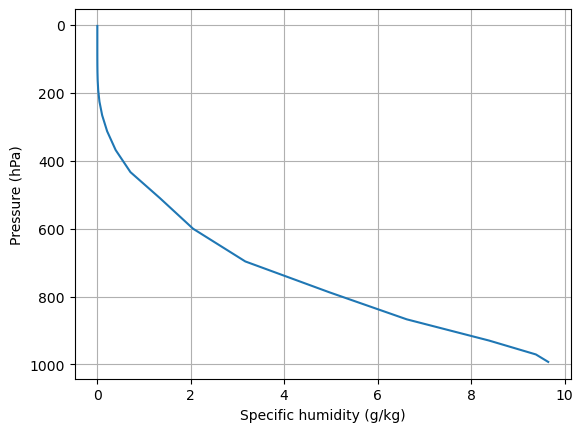

In [88]:
#  Load the model output as we have done before
cesm_data_path = "http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/"
atm_control = xr.open_dataset(cesm_data_path + "cpl_1850_f19/concatenated/cpl_1850_f19.cam.h0.nc")
#  The specific humidity is stored in the variable called Q in this dataset:
atm_control.Q

# Take global, annual average of the specific humidity
weight_factor = atm_control.gw / atm_control.gw.mean(dim='lat')
Qglobal = (atm_control.Q * weight_factor).mean(dim=('lat','lon','time'))
# Take a look at what we just calculated ... it should be one-dimensional (vertical levels)
Qglobal

fig, ax = plt.subplots()
#  Multiply Qglobal by 1000 to put in units of grams water vapor per kg of air
ax.plot(Qglobal*1000., Qglobal.lev)
ax.invert_yaxis()
ax.set_ylabel('Pressure (hPa)')
ax.set_xlabel('Specific humidity (g/kg)')
ax.grid()

## B. All-sky conditions 
Now let's add some cloud to the model. 

Reference: cloud profile like https://github.com/climlab/climlab/blob/9584063ae4dca19f8fb3ffdb5aa399eaff18fdba/climlab/tests/test_rrtm.py#L65


In [308]:
mystate = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)
mystate

AttrDict({'Ts': Field([288.]), 'Tatm': Field([200.  , 203.12, 206.24, 209.36, 212.48, 215.6 , 218.72, 221.84,
       224.96, 228.08, 231.2 , 234.32, 237.44, 240.56, 243.68, 246.8 ,
       249.92, 253.04, 256.16, 259.28, 262.4 , 265.52, 268.64, 271.76,
       274.88, 278.  ])})

In [367]:
mystate
lev = Qglobal.lev
cldfrac = 0.5 # layer cloud fraction
r_liq = 10.  # Cloud water drop effective radius (microns)
clwp = 40  # in-cloud liquid water path (g/m2)
#  The cloud fraction is a Gaussian bump centered at level i
i = 18
cldfrac = np.array(cldfrac*(np.exp(-(lev-lev[i])**2/(2*i)**2)))**0.03 * cldfrac
mycloud = {'cldfrac': np.zeros_like(mystate.Tatm) + cldfrac,
            'clwp': np.zeros_like(mystate.Tatm) + clwp,
            'r_liq': np.zeros_like(mystate.Tatm) + r_liq,
            }

mycloud

{'cldfrac': Field([0.00127852, 0.00139875, 0.00162871, 0.00204382, 0.00274553,
        0.00386567, 0.00549731, 0.00748097, 0.01001154, 0.01391624,
        0.02012252, 0.03026191, 0.04719212, 0.07575764, 0.12346505,
        0.19951248, 0.30779561, 0.42757608, 0.48971015, 0.40586732,
        0.21921237, 0.08264158, 0.02575093, 0.00838249, 0.00364569,
        0.00225622]),
 'clwp': Field([40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40.,
        40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40.]),
 'r_liq': Field([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])}

### Check out vertical profile of clouds

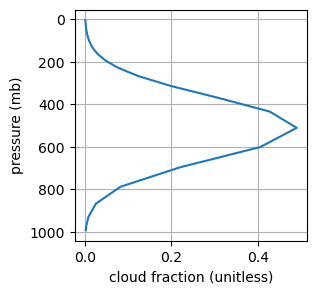

In [368]:
plt.figure(figsize=(3,3))
plt.plot(cldfrac,lev)
plt.gca().invert_yaxis()
plt.ylabel('pressure (mb)'), plt.xlabel('cloud fraction (unitless)'),plt.grid();

# 2. How are clouds represented in RRTMG? 

## A. Model Schemes on Cloud Representation: Cloud Overlap

Remember the infinite combination of how cloud can be organized within a grid cell? McICA comes into play! 

**elaborate the main types of cloud organization methods like random, maximum and random maximum. make note of the latest updates and field focus on exponential - but it is not available in climlab :(** 

**insert graph with the 3 methods from Zhang and Jing 2016 - downloaded** 

In [369]:
# Cloud overlap methods. 0: Clear only, 1: Random, 2,  Maximum/random 3: Maximum

# 3 models, one SW and one LW to do manual McICA, one combined model to compare with.
overlap_types = ['0. Clear','1. Random','2. Maximum_random','3. Maximum','4. Exponential']

def initmodels(ICLD): 
    # initialize model with set cloud overlap method, other values are same as before.
    radmodel_sw = climlab.radiation.RRTMG_SW(name='Radiation (all gases)',  # give our model a name!
                              state=mystate,   # give our model an initial condition!
                              specific_humidity=Qglobal.values,  # tell the model how much water vapor there is
                              albedo = 0.25,  # this the SURFACE shortwave albedo
                              timestep = climlab.constants.seconds_per_day,  # set the timestep to one day (measured in seconds)
                              icld = ICLD,
                              **mycloud
                             )

    radmodel_lw = climlab.radiation.RRTMG_LW(name='Radiation (all gases)',  # give our model a name!
                                state=mystate,   # give our model an initial condition!
                                specific_humidity=Qglobal.values,  # tell the model how much water vapor there is
                                albedo = 0.25,  # this the SURFACE shortwave albedo
                                timestep = climlab.constants.seconds_per_day,  # set the timestep to one day (measured in seconds)
                                icld = ICLD,
                                **mycloud
                                )
    p_lev = radmodel_sw.lev_bounds
    dz = dz_from_p(p_lev)
    return radmodel_sw,radmodel_lw,p_lev,dz

def read_netflux(radmodel_sw,radmodel_lw):
    # a possible assignment
    swnet = radmodel_sw.SW_flux_net
    lwnet = radmodel_lw.LW_flux_net
    return swnet,lwnet

def plot_net_fluxes(radmodel_sw,radmodel_lw):
    swnet,lwnet = read_netflux(radmodel_sw,radmodel_lw)
    plt.figure(figsize=(5,3))
    plt.plot(swnet,p_lev,label='net ↓F_sw')
    plt.plot(lwnet,p_lev,label='net ↑F_lw')
    plt.gca().invert_yaxis()
    plt.grid()
    plt.legend()
    plt.xlim(-100,300)
    plt.title(overlap_types[radmodel_sw.icld])
    plt.show()

def plot_all_fluxes(radmodel_sw,radmodel_lw):
    swd,lwd,swu,lwu = radmodel_sw.SW_flux_down,radmodel_lw.LW_flux_down,radmodel_sw.SW_flux_up,radmodel_lw.LW_flux_up,
    plt.figure(figsize=(5,3))
    plt.plot(swd,p_lev,label='↓F_sw',color='C0')
    plt.plot(lwd,p_lev,label='↓F_lw',color='C1')
    plt.plot(swu,p_lev,label='↑F_sw',color='C0',linestyle='dashed')
    plt.plot(lwu,p_lev,label='↑F_lw',color='C1',linestyle='dashed')
    plt.gca().invert_yaxis()
    plt.grid()
    plt.legend()
    plt.xlim(-100,500)
    plt.title(overlap_types[radmodel_sw.icld])
    plt.show()

### Flux differences due to different cloud overlaps

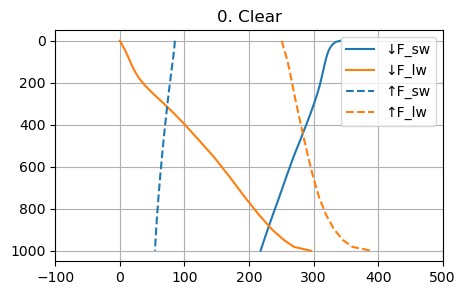

In [371]:
# experiment with different overlap method and nmicia
icld = 0 # no cloud
nmcica = 1 # no need to do multiple mcica since no cloud

radmodel_sw,radmodel_lw,p_lev,dz = initmodels(icld)
step_model(radmodel_sw,radmodel_lw,nmcica)
#plot_net_fluxes(radmodel_sw,radmodel_lw)
plot_all_fluxes(radmodel_sw,radmodel_lw)

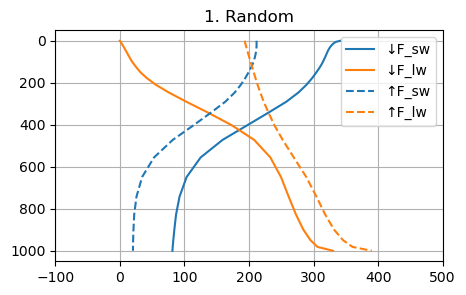

In [372]:
# experiment with different overlap method and nmicia
icld = 1
nmcica = 100

radmodel_sw,radmodel_lw,p_lev,dz = initmodels(icld)
step_model(radmodel_sw,radmodel_lw,nmcica)
#plot_net_fluxes(radmodel_sw,radmodel_lw)
plot_all_fluxes(radmodel_sw,radmodel_lw)

Upper atmosphere: cloud results in more reflected SW flux (up) and less outgoing lw flux (up). \
Lower atmosphere: cloud results in less transmitted SW flux (down) and more downward lw flux emission.

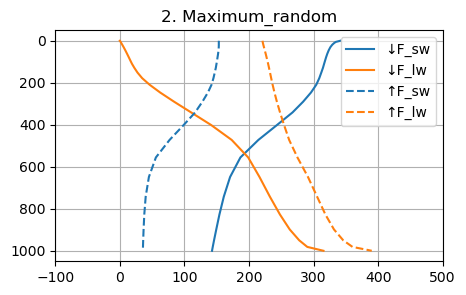

In [374]:
icld = 2
nmcica = 100

radmodel_sw,radmodel_lw,p_lev,dz = initmodels(icld)
step_model(radmodel_sw,radmodel_lw,nmcica)
#plot_net_fluxes(radmodel_sw,radmodel_lw)
plot_all_fluxes(radmodel_sw,radmodel_lw)

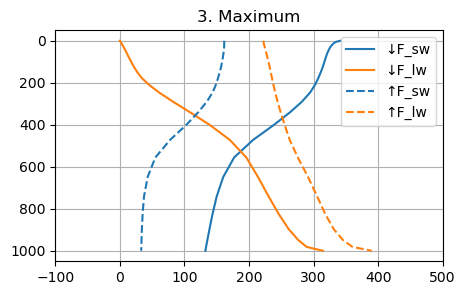

In [379]:
icld = 3
nmcica = 100

radmodel_sw,radmodel_lw,p_lev,dz = initmodels(icld)
step_model(radmodel_sw,radmodel_lw,nmcica)
#plot_net_fluxes(radmodel_sw,radmodel_lw)
plot_all_fluxes(radmodel_sw,radmodel_lw)

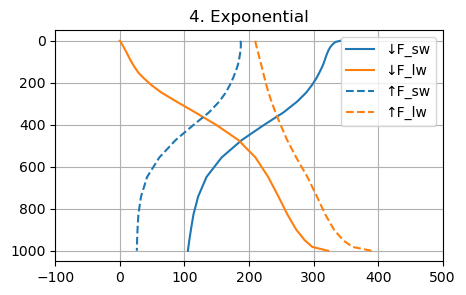

In [375]:
icld = 4
nmcica = 100

radmodel_sw,radmodel_lw,p_lev,dz = initmodels(icld)
step_model(radmodel_sw,radmodel_lw,nmcica)
#plot_net_fluxes(radmodel_sw,radmodel_lw)
plot_all_fluxes(radmodel_sw,radmodel_lw)

Why different overlap methods yield different results?:
- check sample binary cloud

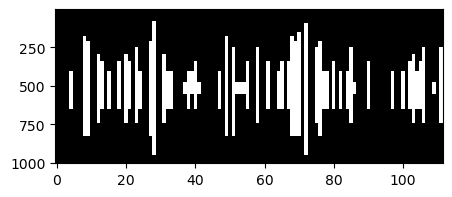

In [386]:
icld = 2
sample_cloud = last_cldfmcl[icld].T # will throw an error if you haven't done type icld before.
extent = [0,112,1000,0]
plt.figure(figsize=(5,2))
plt.pcolormesh(np.arange(ngptsw), lev, sample_cloud, cmap='binary_r', shading='auto')
plt.gca().invert_yaxis()

More clear columns typically lead to more transmission